# Implementation of the Easy21 game from David Silver's RL Slides.

## Describing the game

- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of red (probability 1/3) or black (probability
2/3).
- There are no aces or picture (face) cards in this game
- At the start of the game both the player and the dealer draw one black
card (fully observed)
- Each turn the player may either stick or hit
- If the player hits then she draws another card from the deck
- If the player sticks she receives no further cards
- The values of the player’s cards are added (black cards) or subtracted (red
cards)
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes
bust” and loses the game (reward -1)
- If the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins; otherwise, the outcome – win (reward +1),
lose (reward -1), or draw (reward 0) – is the player with the largest sum.

### Part 1: Implementation of Easy21

State s is the tuple (top, sum), action a is 0 for hit and 1 for stick. 

In [29]:
import random, numpy as np

In [30]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [31]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1] < 1: # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, 0
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.


### Step 2: Monte Carlo Control Implementation

In [32]:
# Initialize the value function, count of states, epsilon, N_0, and alpha.
N = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
V = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
N0 = 100

player_value = random.randint(1, 10)
dealer_value = random.randint(1, 10)

number_of_episodes = 10000000

for episode in range(number_of_episodes):
    player_value = random.randint(1, 10) # reset player value
    dealer_value = random.randint(1, 10) # reset dealer value
    s = (dealer_value, player_value) # initial state
    a = 0 if random.random() < 0.5 else 1 # choose first action randomly

    while True:
        s_new, r = step(s, a) # take a step in the game
        if s_new[1] >= 1 and s_new[1] <= 21:
            N[s_new[0], s_new[1], a] += 1 # update count of states
            alpha_t = 1 / N[s_new[0], s_new[1], a] # calculate alpha
            V[s_new[0], s_new[1], a] += alpha_t * (r + np.max(V[s_new[0], :, :]) - V[s_new[0], s_new[1], a]) # update value function

        if r != 0: # if the game is over, break the loop
            break

        s = s_new # update state
        epsilon_t = N0 / (N0 + N[s[0], s[1], a])
        a = np.argmax(V[s[0], s[1], :]) if random.random() > epsilon_t else random.randint(0, 1) # choose next action using epsilon-greedy policy


In [33]:
print("Value function for Easy21:"
      "\nHit Action:\n", V[:, :, 0],
      "\nStick Action:\n", V[:, :, 1])

Value function for Easy21:
Hit Action:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         14.31013615 14.31543296 14.32213176 14.31927045 14.31946814
  14.31461152 14.32123904 14.31823564 14.32163713 14.31959402 14.31240838
  14.31885351 14.32188685 14.32092533 14.3175844  14.32157539 14.32390502
  14.32291415 14.32428268 14.32737626 14.2994267 ]
 [ 0.         12.31844359 12.3183094  12.32382512 12.31304087 12.32244395
  12.31825988 12.32074828 12.31339872 12.31791506 12.32096274 12.31396724
  12.31440028 12.31815954 12.31471729 12.3206527  12.31648336 12.31652091
  12.32092654 12.32508701 12.32659899 12.30578723]
 [ 0.         14.85629031 14.85661757 14.85323738 14.85309838 14.85727941
  14.85599326 14.85595084 14.85604165 14.85484398 14.85690695 14.85157683
  14.8494138  14.

In [34]:
Z_0 = np.transpose(V[:, :, 0])
Z_1 = np.transpose(V[:, :, 1])
Z = np.maximum(Z_0, Z_1)

In [35]:
print("\nOptimal Value Function:\n", Z)


Optimal Value Function:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         14.31013615 12.31844359 14.85629031 18.27463117 10.91173402
  15.6233285  17.51131059 17.51323015 18.27195837 14.93478518]
 [ 0.         14.31543296 12.3183094  14.85661757 18.27631228 10.91814357
  15.62124782 17.51252344 17.50324248 18.28377431 14.93593001]
 [ 0.         14.32213176 12.32382512 14.85323738 18.27872316 10.91550354
  15.62128564 17.51430785 17.5141647  18.27815748 14.9341144 ]
 [ 0.         14.31927045 12.31304087 14.85309838 18.28727558 10.92735635
  15.62369362 17.51620338 17.50271301 18.28422904 14.92263632]
 [ 0.         14.31946814 12.32244395 14.85727941 18.27795009 10.92391205
  15.62252689 17.52054907 17.50513471 18.27993752 14.94041353]
 [ 0.         14.31461152 12.31825988 14.85599326 18.2755255  10.92855381
  15.61815176 17.51573164 17.51137845 18.28030802 14.92778984]
 [ 0.         14.321239

### Plotting the value function

In [36]:
import matplotlib.pyplot as plt

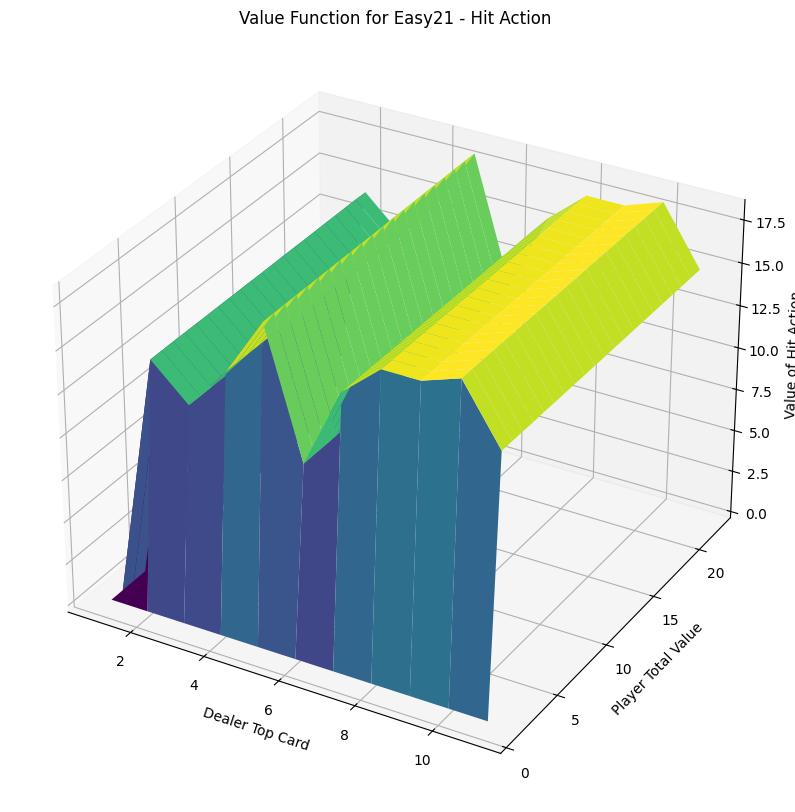

In [37]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(1, 12), np.arange(1, 23))
ax.plot_surface(X, Y, Z_0, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Hit Action')
plt.show()

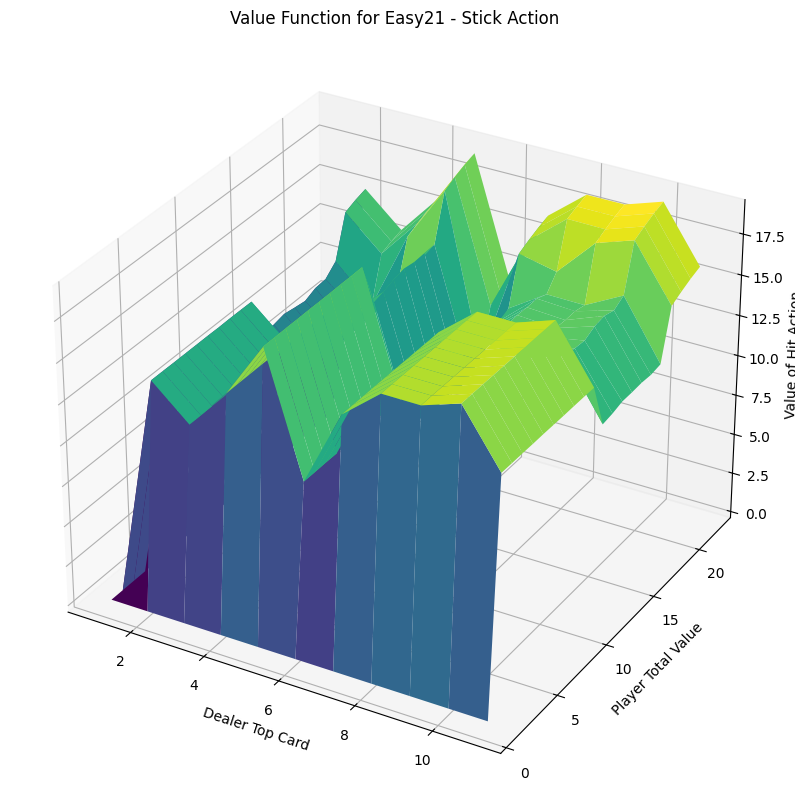

In [38]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_1, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Stick Action')
plt.show()

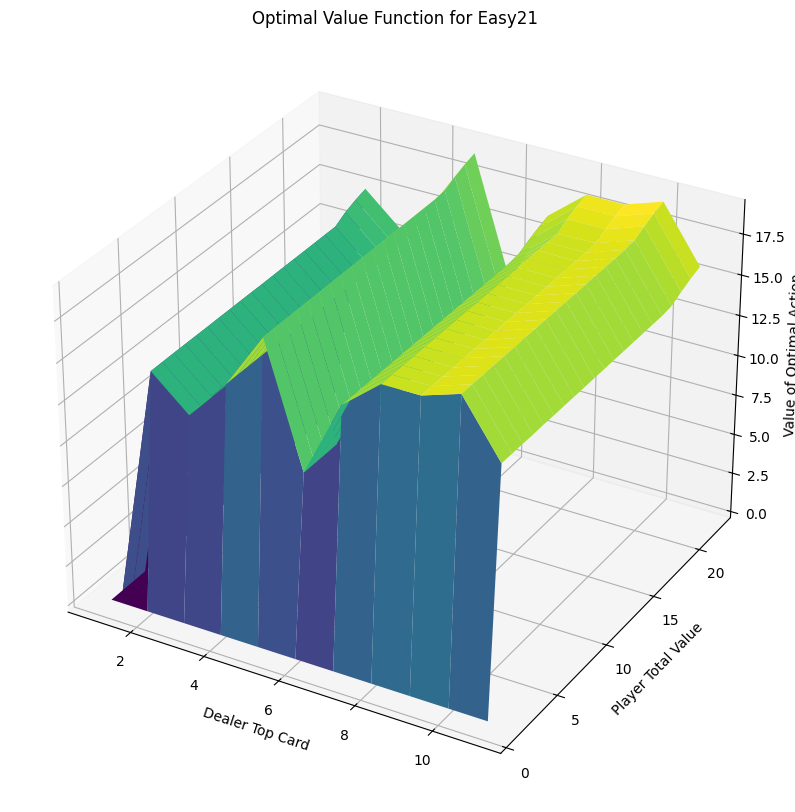

In [40]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Optimal Action')
ax.set_title('Optimal Value Function for Easy21')
plt.show()